### Import Dependencies

In [1002]:
import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import missingno as msno
from tqdm import tqdm
from wordcloud import WordCloud

In [1003]:
# Function to read data from source
def get_data(file_name: str) -> pd.DataFrame:
    """
    Load a JSON Lines (.jsonl) file into a pandas DataFrame.

    This function reads newline-delimited JSON (JSONL) files, where each line
    is a valid JSON object.

    Parameters
    ----------
    file_name : str
        Name of the JSONL file located inside the 'data/' directory.

    Returns
    -------
    pd.DataFrame
        A pandas DataFrame containing the parsed JSONL data.
    """
    base_dir: Path = Path.cwd()
    file_path: Path = base_dir / "data" / file_name

    return pd.read_json(
        file_path,
        lines=True,
        convert_dates=False
    )

In [1004]:
# Reading data
df = get_data(r'message_dump_2.jsonl')

In [1005]:
# Preview of data
df.head(5)

,message_id,channel_id,author_id,content,created_at,edited_at,deleted_at,mention_ids,reply_to_message_id,attachment_count,embed_count
0,704751211860983936,699975135905710208,698185293420822649,"Hi Friends,",1588096182552,NaN,NaN,[],None,0,0
1,704751384657920128,699975135905710208,698185293420822649,"Need a help , am able group/resample the data ...",1588096223750,NaN,NaN,[],None,0,0
2,704751414471294976,699975135905710208,698185293420822649,,1588096230858,NaN,NaN,[],None,1,0
3,704751722794319872,699975135905710208,698185293420822649,is there a way we have a interval based output...,1588096304368,NaN,NaN,[],None,0,0
4,704751946799513728,699975135905710208,698185293420822649,any function that can tweak or do i need to it...,1588096357775,NaN,NaN,[],None,0,0


In [1006]:
# Shape of data
df.shape

(69790, 11)

In [1007]:
# data dtypes of features
df.dtypes

message_id               int64
channel_id               int64
author_id               object
content                 object
created_at               int64
edited_at              float64
deleted_at             float64
mention_ids             object
reply_to_message_id     object
attachment_count         int64
embed_count              int64
dtype: object

### Null values

In [1008]:
# Checking for null values
df.isna().sum().to_frame(name="null_count")

,null_count
message_id,0
channel_id,0
author_id,0
content,0
created_at,0
edited_at,66228
deleted_at,69679
mention_ids,0
reply_to_message_id,0
attachment_count,0


In [1009]:
# Replacing [] with Nan values
df["mention_ids"] = df["mention_ids"].apply(
    lambda x: np.nan if x == [] else x
)

📌 Missing Value Representation – mention_ids

The mention_ids column does not consistently use null values to represent missing data. Instead of NaN, several rows contain empty lists []. This representation masks the true count of missing or absent values when standard null checks are applied.

In [1010]:
# Checking for null values
df.isna().sum().to_frame(name="null_count")

,null_count
message_id,0
channel_id,0
author_id,0
content,0
created_at,0
edited_at,66228
deleted_at,69679
mention_ids,55347
reply_to_message_id,0
attachment_count,0


In [1011]:
df.loc[df.content == "", 'content']

2         
12        
66        
69        
105       
        ..
69667     
69706     
69713     
69758     
69776     
Name: content, Length: 1617, dtype: object

In [1012]:
df = df.assign(
    content = df.content.apply(lambda x: np.nan if x == "" else x)
)

📌 Empty Content Analysis

An analysis of the content column reveals the presence of 1,601 instances where the message content is an empty string. These entries are not recorded as null values but appear as blank text fields.

This indicates that certain messages exist in the dataset without any textual content while still being represented as valid records. The absence of text is therefore embedded within the data values themselves rather than being reflected through missing value indicators.

Overall, the content column includes a small but notable subset of messages with empty content, which may influence text-based analysis and summary statistics if not explicitly accounted for.

In [1013]:
df.reply_to_message_id.value_counts()

reply_to_message_id
None                   64207
1307050131148898385       12
1389114038184575117        5
1413740169009299518        5
1326813346057687041        4
                       ...  
1466985613994754282        1
1466861908052414506        1
1466742369058820166        1
1466722027158245513        1
1466525179805962340        1
Name: count, Length: 4979, dtype: int64

In [1014]:
df = df.assign(
    reply_to_msg_id = df.reply_to_message_id.apply(lambda x: np.nan if x == 'None' else x)
).drop('reply_to_message_id', axis=1)

In [1015]:
# Checking for null values
df.isna().sum().to_frame(name="null_count")

,null_count
message_id,0
channel_id,0
author_id,0
content,1617
created_at,0
edited_at,66228
deleted_at,69679
mention_ids,55347
attachment_count,0
embed_count,0


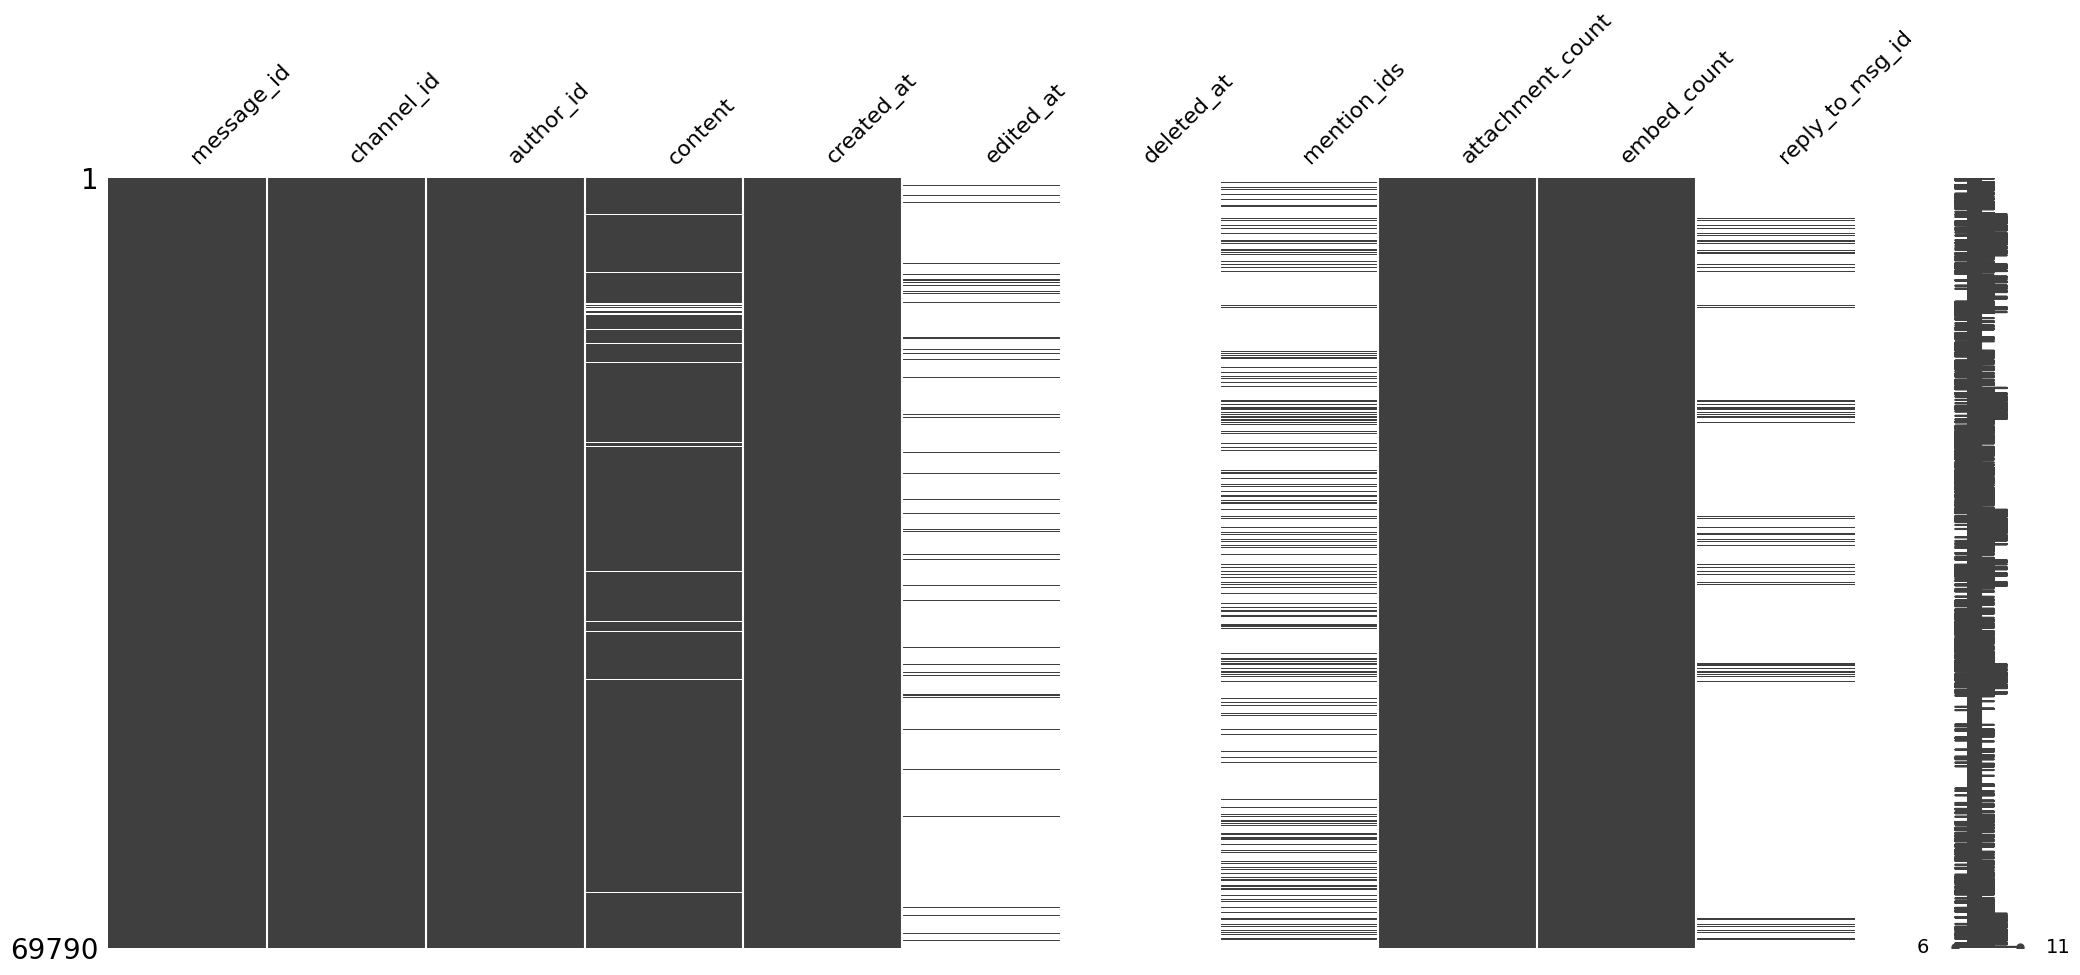

In [1016]:
# Matrix plot
msno.matrix(
    df = df,
    label_rotation=45,
    sparkline=True,
)
plt.show()

📌 Missing Value Distribution Across Columns

The dataset contains several columns that are fully populated, including message_id, channel_id, author_id, created_at, attachment_count, and embed_count. These fields show no missing values, indicating consistent availability of core message identifiers and metadata.

Missing values are present in multiple content-related and event-dependent columns. The content column has 1,617 missing entries, reflecting messages without textual content. A large number of missing values are observed in edited_at and deleted_at, with 66,228 and 69,679 null entries respectively.

The mention_ids column also exhibits substantial missingness, with 55,347 entries lacking values. In addition, reply_to_msg_id contains 64,207 missing entries, indicating that a majority of messages are not replies to other messages.

Overall, missing values are concentrated in optional or context-specific fields, while essential identifiers and structural attributes remain consistently populated across the dataset.

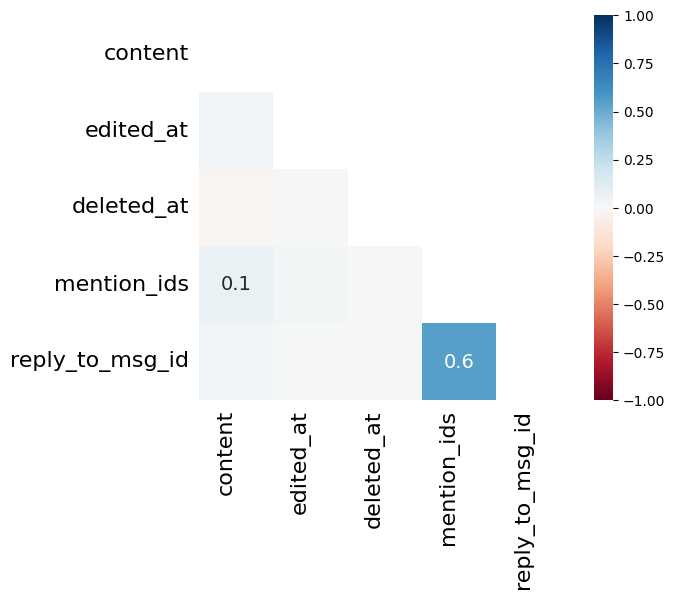

In [1017]:
# Heat map
msno.heatmap(
    df, 
    figsize=(6,5), 
    label_rotation=90, 
    labels=True
)
plt.show()

📌 Missing Value Relationship Heatmap – Observations

The heatmap shows the correlation between missing values across selected columns, including content, edited_at, deleted_at, mention_ids, and reply_to_msg_id. Overall, most relationships exhibit low correlation, indicating that missingness in these fields generally occurs independently.

A weak positive correlation of approximately 0.1 is observed between missing values in content and mention_ids. This suggests a slight overlap where messages without content are marginally more likely to lack mention information, though the association remains minimal.

The strongest relationship appears between missing values in mention_ids and reply_to_msg_id, with a correlation close to 0.6. This indicates a noticeable co-occurrence where messages without mentions are frequently also not replies to other messages.

Missingness in edited_at and deleted_at shows little to no correlation with other columns, suggesting that message edits and deletions are largely independent of content presence, mentions, or reply behavior.

Overall, the heatmap highlights one prominent association involving mention_ids and reply_to_msg_id, while other missing value relationships remain weak and scattered across the dataset.

In [1018]:
df.head(5)

,message_id,channel_id,author_id,content,created_at,edited_at,deleted_at,mention_ids,attachment_count,embed_count,reply_to_msg_id
0,704751211860983936,699975135905710208,698185293420822649,"Hi Friends,",1588096182552,NaN,NaN,NaN,0,0,NaN
1,704751384657920128,699975135905710208,698185293420822649,"Need a help , am able group/resample the data ...",1588096223750,NaN,NaN,NaN,0,0,NaN
2,704751414471294976,699975135905710208,698185293420822649,NaN,1588096230858,NaN,NaN,NaN,1,0,NaN
3,704751722794319872,699975135905710208,698185293420822649,is there a way we have a interval based output...,1588096304368,NaN,NaN,NaN,0,0,NaN
4,704751946799513728,699975135905710208,698185293420822649,any function that can tweak or do i need to it...,1588096357775,NaN,NaN,NaN,0,0,NaN


In [1019]:
# type value counts
for col in df.columns:
    if col == 'created_at':
        continue
    print(df[col].apply(type).value_counts(dropna=False))
    print('='*50)

message_id
<class 'int'>    69790
Name: count, dtype: int64
channel_id
<class 'int'>    69790
Name: count, dtype: int64
author_id
<class 'str'>    69790
Name: count, dtype: int64
content
<class 'str'>      68173
<class 'float'>     1617
Name: count, dtype: int64
edited_at
<class 'float'>    69790
Name: count, dtype: int64
deleted_at
<class 'float'>    69790
Name: count, dtype: int64
mention_ids
<class 'float'>    55347
<class 'list'>     14443
Name: count, dtype: int64
attachment_count
<class 'int'>    69790
Name: count, dtype: int64
embed_count
<class 'int'>    69790
Name: count, dtype: int64
reply_to_msg_id
<class 'float'>    64207
<class 'str'>       5583
Name: count, dtype: int64


In [1020]:
df.loc[df.mention_ids.apply(type) == list, 'mention_ids']

7          [95605730538684416]
15        [635543257979420672]
21        [248596780789268481]
25        [483296676824481792]
26        [248596780789268481]
                 ...          
69753    [1168496774328102983]
69757     [304655299631906816]
69778     [767694543231385630]
69785    [1410737019855966440]
69786    [1420445590864662568]
Name: mention_ids, Length: 14443, dtype: object

The coexistence of float and list types within the same column introduces structural inconsistency in the dataset. This inconsistency affects uniform processing of the column, as operations expecting a single data type cannot be applied reliably across all records.

In [1021]:
df["mention_ids"] = df["mention_ids"].apply(
    lambda x: x[0] if isinstance(x, list) else x
)

In [1022]:
df.mention_ids.apply(type).value_counts()

mention_ids
<class 'float'>    55347
<class 'str'>      14443
Name: count, dtype: int64

In [1023]:
# Checking for duplicate instances
df.duplicated().sum()

np.int64(0)

📌 Duplicate values

There are no duplicates in the data which indicates that every row is unique.

In [1024]:
# Number of unique values in each feature
for col in df.columns:
    print(f'nunique values in {col}: {df[col].nunique()}')
    print('='*50)

nunique values in message_id: 69790
nunique values in channel_id: 12
nunique values in author_id: 8006
nunique values in content: 62098
nunique values in created_at: 69790
nunique values in edited_at: 3562
nunique values in deleted_at: 98
nunique values in mention_ids: 3422
nunique values in attachment_count: 8
nunique values in embed_count: 6
nunique values in reply_to_msg_id: 4978


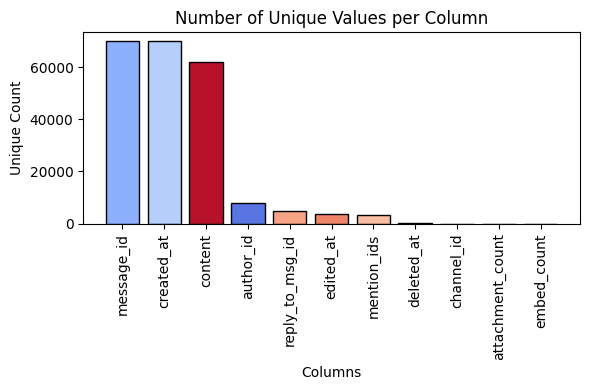

In [1025]:
nunique = df.nunique().sort_values(ascending=False)

colors = np.random.rand(len(nunique))

fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(
    nunique.index,
    nunique.values,
    edgecolor="black",
    linewidth=1,
    color = plt.cm.coolwarm(colors),
)

ax.set_title("Number of Unique Values per Column")
ax.set_xlabel("Columns")
ax.set_ylabel("Unique Count")
ax.tick_params(axis="x", rotation=90)

plt.tight_layout()
plt.show()

### user_id

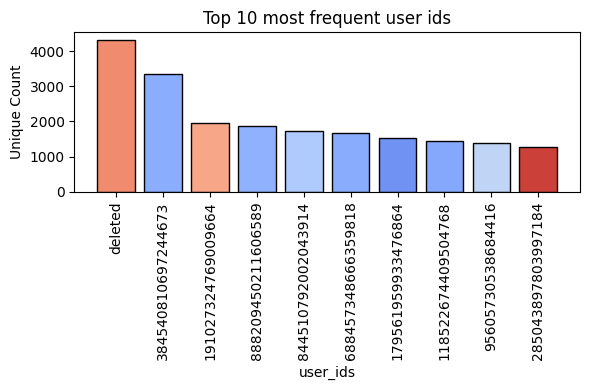

In [1026]:
top_user_ids = df.author_id.value_counts().sort_values(ascending=False).nlargest(n=10)

colors = np.random.rand(len(top_user_ids))

fig, ax = plt.subplots(figsize=(6,4))
ax.bar(
    top_user_ids.index,
    top_user_ids.values,
    color = plt.cm.coolwarm(colors),
    edgecolor='black'
)

ax.set_title('Top 10 most frequent user ids')
ax.set_xlabel("user_ids")
ax.set_ylabel("Unique Count")
ax.tick_params(axis="x", rotation=90)

plt.tight_layout()
plt.show()

### channel_id

In [1027]:
df.dtypes

message_id            int64
channel_id            int64
author_id            object
content              object
created_at            int64
edited_at           float64
deleted_at          float64
mention_ids          object
attachment_count      int64
embed_count           int64
reply_to_msg_id      object
dtype: object

In [1028]:
# Convert ids into strings for better analysis

df = df.assign(
    message_id = df.message_id.astype(str),
    edited_at = df.edited_at.astype(str),
    created_at  = df.created_at.astype(str),
    deleted_at = df.deleted_at.astype(str),
    channel_id = df.channel_id.astype(str)
)

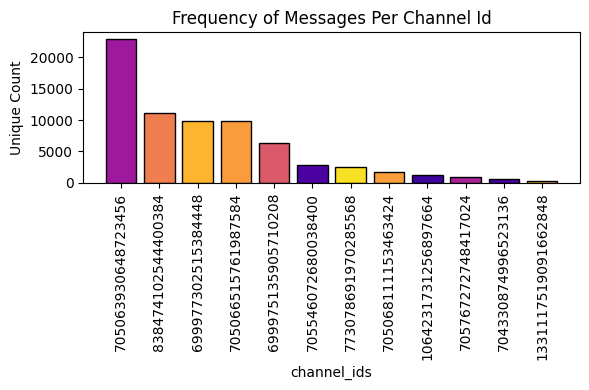

In [1029]:
top_channel_id = df.channel_id.value_counts().sort_values(ascending=False)

colors = np.random.rand(len(top_channel_id))

fig, ax = plt.subplots(figsize=(6,4))
ax.bar(
    top_channel_id.index,
    top_channel_id.values,
    color = plt.cm.plasma(colors),
    edgecolor='black'
)

ax.set_title('Frequency of Messages Per Channel Id')
ax.set_xlabel("channel_ids")
ax.set_ylabel("Unique Count")
ax.tick_params(axis="x", rotation=90)

plt.tight_layout()
plt.show()

📌 Message Frequency Distribution Across Channel IDs

The bar chart shows a highly skewed distribution of messages across channel IDs. One channel dominates the dataset with a significantly higher message count compared to all others, indicating a primary hub of activity.

A small group of channels forms a second tier with moderately high message volumes, but their counts are notably lower than the most active channel. These channels still contribute a substantial portion of overall messages relative to the rest.

Beyond the top few channels, message frequency drops sharply. Most remaining channels exhibit relatively low message counts, forming a long tail of low-activity channels.

Overall, message activity is concentrated within a limited number of channels, while the majority of channels show sparse participation and lower engagement levels.

### attachment_count

In [1030]:
df.attachment_count.value_counts()

attachment_count
0    66777
1     2844
2      118
3       24
4       16
6        5
5        4
7        2
Name: count, dtype: int64

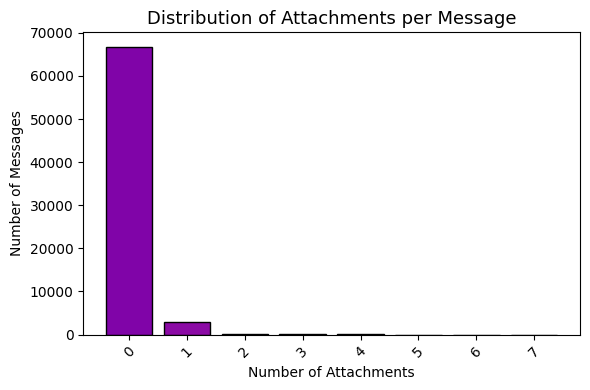

In [1031]:
attachment_count = df.attachment_count.value_counts().sort_values(ascending=False)

colors = np.random.rand(len(attachment_count))

fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(
    attachment_count.index,
    attachment_count.values,
    color=plt.cm.plasma(colors),
    edgecolor="black"
)

ax.set_title("Distribution of Attachments per Message", fontsize=13)
ax.set_xlabel("Number of Attachments")
ax.set_ylabel("Number of Messages")

ax.tick_params(axis="x", rotation=45)
plt.tight_layout()
plt.show()

📌 Attachment Count Distribution in Messages

The majority of messages contain no attachments, with 66,069 messages having an attachment_count of zero. This indicates that attachments are not commonly used in most message.

Messages with a single attachment form a much smaller group, totaling 2,822 instances. As the number of attachments increases, the frequency of messages drops sharply. Only 117 messages contain two attachments, and counts beyond this point decrease to a few dozen or single-digit occurrences.

Messages with three or more attachments are rare, with the highest observed attachment count being seven, appearing in only two messages. Overall, the distribution is heavily skewed toward messages without attachments, with multi-attachment messages occurring infrequently across the dataset.

In [1032]:
df.dtypes

message_id          object
channel_id          object
author_id           object
content             object
created_at          object
edited_at           object
deleted_at          object
mention_ids         object
attachment_count     int64
embed_count          int64
reply_to_msg_id     object
dtype: object

## embed_count

In [1033]:
df.embed_count.value_counts()

embed_count
0    67435
1     2224
2       98
3       18
5        9
4        6
Name: count, dtype: int64

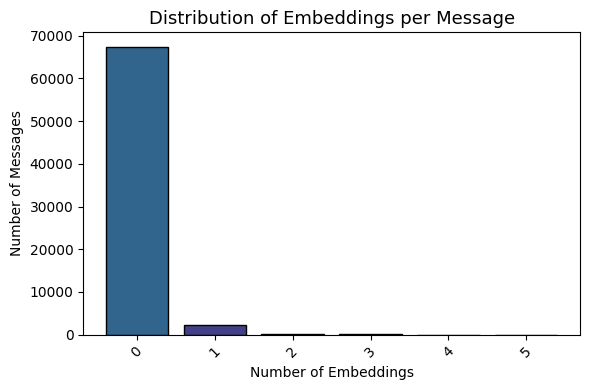

In [1034]:
emb_count = df.embed_count.value_counts().sort_values(ascending=False)

colors = np.random.rand(len(emb_count))

fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(
    emb_count.index,
    emb_count.values,
    color=plt.cm.viridis(colors),
    edgecolor="black"
)

ax.set_title("Distribution of Embeddings per Message", fontsize=13)
ax.set_xlabel("Number of Embeddings")
ax.set_ylabel("Number of Messages")

ax.tick_params(axis="x", rotation=45)
plt.tight_layout()
plt.show()

📌 Embed Count Distribution in Messages

The embed_count distribution shows that the majority of messages do not contain any embedded content. A total of 67,435 messages have an embed_count of zero, indicating that embeds are rarely used in most communications.

Messages containing a single embed are far less common, with 2,224 occurrences. As the number of embeds increases, the frequency of messages declines sharply. Only 98 messages contain two embeds, and counts beyond this point drop to fewer than 20 instances.

Messages with four or five embeds are extremely rare, appearing only a handful of times in the dataset. Overall, the distribution is heavily skewed toward messages without embeds, with multi-embed messages representing a very small fraction of total activity.